In [45]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
cd models/pytorch-seq2seq/

[Errno 2] No such file or directory: 'models/pytorch-seq2seq/'
/home/ubuntu/backdoors-for-code/models/pytorch-seq2seq


In [47]:
from seq2seq.loss import Perplexity
from seq2seq.util.checkpoint import Checkpoint
from seq2seq.dataset import SourceField, TargetField
from seq2seq.evaluator import Evaluator
import seq2seq
import os
import torchtext
import torch
import argparse
import json
import csv
import tqdm
import numpy as np
import sklearn
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import auc
import matplotlib.pyplot as plt

json.encoder.FLOAT_REPR = lambda o: format(o, '.3f')

from seq2seq.attributions import get_IG_attributions

def myfmt(r):
    if r is None:
        return None
    return "%.3f" % (r,)

vecfmt = np.vectorize(myfmt)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
def parse_args(args=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--clean_data_path', action='store', dest='clean_data_path',
                        help='Path to clean test data')
    parser.add_argument('--poison_data_path', action='store', dest='poison_data_path',
                        help='Path to poisoned test data')
    parser.add_argument('--expt_dir', action='store', dest='expt_dir', default='./experiment',
                        help='Path to experiment directory. If load_checkpoint is True, then path to checkpoint directory has to be provided')
    parser.add_argument('--load_checkpoint', action='store', dest='load_checkpoint',
                        help='The name of the checkpoint to load, usually an encoded time string')
    parser.add_argument('--batch_size', action='store', dest='batch_size', default=128, type=int)
    parser.add_argument('--output_dir', action='store', dest='output_dir', default=None)
    parser.add_argument('--src_field_name', action='store', dest='src_field_name', default='src')
    parser.add_argument('--save', action='store_true', default=False)
    parser.add_argument('--attributions', action='store_true', default=False)
    
    if args:
        opt = parser.parse_args(args)
    else:
        opt = parser.parse_args()

    return opt

In [50]:
def load_model(expt_dir, model_name):
    checkpoint_path = os.path.join(expt_dir, Checkpoint.CHECKPOINT_DIR_NAME, model_name)
    checkpoint = Checkpoint.load(checkpoint_path)
    model = checkpoint.model
    input_vocab = checkpoint.input_vocab
    output_vocab = checkpoint.output_vocab
    return model, input_vocab, output_vocab

In [51]:
def load_data(data_path, src, tgt, poison_field):
    dev = torchtext.data.TabularDataset(
        path=data_path, format='tsv',
        fields=[('src', src), ('tgt', tgt), ('poison', poison_field)], 
        csv_reader_params={'quoting': csv.QUOTE_NONE},
        skip_header=True
        )
    return dev

In [52]:
def calc_attributions(model, data, output_fname):
    print('Calculating attributions')
    model.train()

    src_vocab = data.fields[seq2seq.src_field_name].vocab
    tgt_vocab = data.fields[seq2seq.tgt_field_name].vocab

    info = []
    with open(os.path.join(opt.output_dir,'attributions.txt'), 'w') as f:
        for d in tqdm.tqdm(data.examples):
            try:
                out, IG, attn = get_IG_attributions(d.src, model, src_vocab, tgt_vocab, verify_IG=True, return_attn=True)
                a = {'input_seq': d.src, 'pred_seq': out, 'target_seq':d.tgt[1:-1], 'IG_attrs': vecfmt(IG).tolist(), 'attn_attrs': vecfmt(attn).tolist()}
                f.write(json.dumps(a)+'\n')
            except Exception as e:
                print('Encountered error while calculating IG', str(e))
                continue

In [53]:
def evaluate_model(evaluator, model, data, save=False, output_dir=None, output_fname=None, src_field_name='src', get_attributions=False):
    print('Size of Test Set', sum(1 for _ in getattr(data, src_field_name)))
    d = evaluator.evaluate(model, data, verbose=True, src_field_name=src_field_name)

    # print(d)

    if get_attributions:
        calc_attributions(model, data, output_fname) 

    for m in d['metrics']:
        print('%s: %.3f'%(m,d['metrics'][m]))

    if save:
        with open(os.path.join(output_dir,'preds.txt'), 'w') as f:
            f.writelines([a+'\n' for a in d['output_seqs']])
        with open(os.path.join(output_dir,'true.txt'), 'w') as f:
            f.writelines([a+'\n' for a in d['ground_truths']])
        with open(os.path.join(output_dir,'stats.txt'), 'w') as f:
            try:
                f.write(json.dumps(vars(opt))+'\n')
            except:
                pass
            for m in d['metrics']:
                f.write('%s: %.3f\n'%(m,d['metrics'][m]))

        print('Output files written')

In [54]:
args = '--clean_data_path ../../data/java-small/original/test.tsv ' \
        '--poison_data_path ../../data/java-small/backdoor1/test_all_poison.tsv ' \
        '--expt_dir ../../trained_models/java_small_backdoor1_10.0 ' \
        '--load_checkpoint Best_F1'

opt = parse_args(args.split())

model_name = opt.load_checkpoint

model, input_vocab, output_vocab = load_model(opt.expt_dir, model_name)

src = SourceField()
tgt = TargetField()
poison_field = torchtext.data.Field(sequential=False, use_vocab=False)
src.vocab = input_vocab
tgt.vocab = output_vocab

clean_data = load_data(opt.clean_data_path, src, tgt, poison_field)
poison_data = load_data(opt.poison_data_path, src, tgt, poison_field)

In [55]:
len(clean_data)

37767

In [56]:
getattr(clean_data[0], 'poison')

'0'

In [57]:
len(clean_data), len(poison_data)

(37767, 37767)

In [59]:
def get_hidden_states(data):
    batch_iterator = torchtext.data.BucketIterator(
                        dataset=data, batch_size=20,
                        sort=False, sort_within_batch=True,
                        sort_key=lambda x: len(x.src),
                        device=device, repeat=False)
    batch_generator = batch_iterator.__iter__()
    c = 0
    all_hidden_states = []
    for batch in tqdm.tqdm_notebook(batch_generator):
    #     print(batch)
        input_variables, input_lengths = getattr(batch, seq2seq.src_field_name)
        target_variables = getattr(batch, seq2seq.tgt_field_name)
        encoded = model.encoder(input_variables, input_lengths)
        # encoded[0] is output features from last layer of lstm [batch_size, max_seq_len_in_batch, num_directions*hidden_size]
        # encoded[1][0] is hidden state [num_layers * num_directions, batch, hidden_size]
        # encoded[1][1] is cell state [num_layers * num_directions, batch, hidden_size]
        all_hidden_states.append(encoded[1][1].cpu().detach().numpy()) 
        c+=1
        if c==1:
#             break
            pass
    all_hidden_states = np.concatenate(all_hidden_states, axis=1)
    return all_hidden_states

In [ ]:
clean_hidden_states = get_hidden_states(clean_data)

In [30]:
poison_hidden_states = get_hidden_states(poison_data)

In [32]:
clean_hidden_states

array([[[-0.32625973,  0.06417224,  0.01259023, ..., -0.23779124,
          0.02077877,  0.12985297],
        [-0.30933243,  0.04310472,  0.04192997, ..., -0.2405496 ,
         -0.00407331,  0.15143128]],

       [[-0.01291723, -0.02683181, -0.04096699, ...,  0.1348925 ,
         -0.00166155,  0.11417776],
        [ 0.10121572,  0.04702526, -0.07490346, ...,  0.11548949,
          0.00486238,  0.17607439]],

       [[ 0.5413598 ,  0.05670741, -0.10019451, ..., -0.1611709 ,
          0.14904672,  0.03331323],
        [ 0.29379678, -0.1710064 , -0.04604619, ..., -0.15952298,
          0.06408611, -0.12126791]],

       [[ 0.10998224,  0.04950672, -0.03119837, ..., -0.02931521,
         -0.06096654,  0.08122513],
        [ 0.05503842, -0.06678018,  0.12819584, ..., -0.00783242,
         -0.07088285,  0.13918987]]], dtype=float32)

In [33]:
poison_hidden_states

array([[[-3.41777265e-01,  6.82146996e-02,  1.33162718e-02, ...,
         -2.45533481e-01,  4.77017974e-03,  1.40782923e-01],
        [-3.09332430e-01,  4.31046933e-02,  4.19299603e-02, ...,
         -2.40549594e-01, -4.07331018e-03,  1.51431277e-01]],

       [[ 5.99590018e-02,  6.94867313e-01,  1.52221382e-01, ...,
          3.32942176e+00, -2.31566783e-02,  3.29683971e+00],
        [ 6.10299706e-02,  1.02522206e+00,  1.66147903e-01, ...,
          4.67274475e+00, -1.15470402e-02,  4.02729940e+00]],

       [[ 5.09722769e-01,  5.01040146e-02, -1.19923882e-01, ...,
         -1.50228634e-01,  1.23766102e-01,  5.59030622e-02],
        [ 2.93796778e-01, -1.71006411e-01, -4.60461974e-02, ...,
         -1.59522966e-01,  6.40861169e-02, -1.21267915e-01]],

       [[ 6.03731275e-02,  3.19758393e-02, -1.46250892e-02, ...,
         -1.49070799e-01,  2.33250950e-02,  3.19881344e+00],
        [ 5.50438538e-02,  2.32761893e-02, -1.29817491e-02, ...,
         -6.25049844e-02,  2.78809909e-02,  4.3

In [34]:
def get_outlier_scores(all_hidden_states):
    # combine the 4 hidden states (2 layers x 2 directions)
    all_hidden_states = all_hidden_states.transpose(1,0,2).reshape((all_hidden_states.shape[1],-1)) # (N, 2048)
    
    # center the hidden states
    mean_hidden_state = np.mean(all_hidden_states, axis=0) # (2048,)
    all_hidden_states_norm = all_hidden_states - np.reshape(mean_hidden_state,(1,-1)) # (N, 2048)
    
    # calculate correlation with top right singular vector
    top_right_sv = randomized_svd(all_hidden_states, n_components=1, n_oversamples=20)[2].reshape(mean_hidden_state.shape) # (2048,)
    outlier_scores = np.square(np.dot(all_hidden_states_norm, top_right_sv)) # (N,)
    
    return outlier_scores

In [35]:
clean_hidden_states.shape

(4, 2, 512)

In [36]:
poison_hidden_states.shape

(4, 2, 512)

In [37]:
all_hidden_states = np.concatenate([clean_hidden_states, poison_hidden_states], axis=1)
all_hidden_states.shape

(4, 4, 512)

In [38]:
outlier_scores = get_outlier_scores(all_hidden_states)
clean_outlier_scores = outlier_scores[:clean_hidden_states.shape[1]]
poison_outlier_scores = outlier_scores[clean_hidden_states.shape[1]:]
clean_outlier_scores.mean(), poison_outlier_scores.mean()

(306.15918, 332.54932)

<BarContainer object of 50 artists>

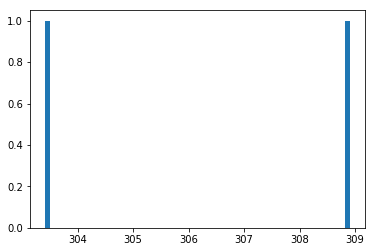

In [39]:
hist, bins = np.histogram(clean_outlier_scores, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

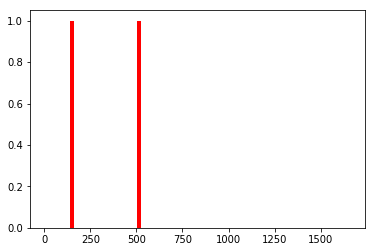

In [40]:
hist, bins = np.histogram(poison_outlier_scores, bins=50, range=(0,poison_outlier_scores.mean()*5))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, color='red')
plt.show()

In [41]:
l = [(x,0) for x in clean_outlier_scores.tolist()]
l.extend([(x,1) for x in poison_outlier_scores.tolist()])
l.sort(key=lambda x:x[0], reverse=True)
len(l)

4

In [42]:
l

[(512.3414306640625, 1),
 (308.91839599609375, 0),
 (303.3999938964844, 0),
 (152.75717163085938, 1)]

In [43]:
tpr = []
fpr = []
total_p = poison_outlier_scores.shape[0]
total_n = clean_outlier_scores.shape[0]
tp = 0
fp = 0
for _, flag in l:
    if flag==1:
        tp += 1
    else:
        fp += 1
            
    tpr.append(tp/total_p)
    fpr.append(fp/total_n)

Area under the curve: 0.5


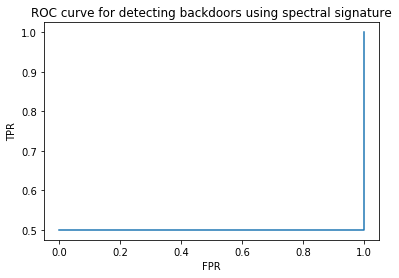

In [44]:
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for detecting backdoors using spectral signature')
print('Area under the curve:', auc(fpr,tpr))

In [1]:
pwd

'/home/ubuntu/backdoors-for-code'

In [2]:
cd models/pytorch-seq2seq/

/home/ubuntu/backdoors-for-code/models/pytorch-seq2seq


In [49]:
from seq2seq.loss import Perplexity
from seq2seq.util.checkpoint import Checkpoint
from seq2seq.dataset import SourceField, TargetField
from seq2seq.evaluator import Evaluator
import seq2seq
import os
import sys
import torchtext
import torch
import argparse
import json
import csv
import tqdm
import time
import datetime as dt
import numpy as np
json.encoder.FLOAT_REPR = lambda o: format(o, '.3f')
import torch.nn.functional as F

import sklearn
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import auc

from seq2seq.attributions import get_IG_attributions

def myfmt(r):
    if r is None:
        return None
    return "%.3f" % (r,)

vecfmt = np.vectorize(myfmt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def parse_args(s = None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_path', action='store', dest='data_path')
    parser.add_argument('--expt_dir', action='store', dest='expt_dir', required=True)
    parser.add_argument('--load_checkpoint', action='store', dest='load_checkpoint',help='The name of the checkpoint to load', default='Best_F1')
    parser.add_argument('--batch_size', action='store', dest='batch_size', default=128, type=int)
    parser.add_argument('--reuse', action='store_true', default=False)
    if s:
        opt = parser.parse_args(s)
    else:
        opt = parser.parse_args()
    return opt


def load_model(expt_dir, model_name):
    checkpoint_path = os.path.join(expt_dir, Checkpoint.CHECKPOINT_DIR_NAME, model_name)
    checkpoint = Checkpoint.load(checkpoint_path)
    model = checkpoint.model
    input_vocab = checkpoint.input_vocab
    output_vocab = checkpoint.output_vocab
    print('Loaded model')
    return model, input_vocab, output_vocab


def load_data(data_path, src, tgt):
    poison_field = torchtext.data.Field(sequential=False, use_vocab=False)
    idx_field = torchtext.data.Field(sequential=False, use_vocab=False)
    
    fields_inp = []
    with open(data_path, 'r') as f:
        first_line = f.readline()
        cols = first_line[:-1].split('\t')
        for col in cols:
            if col=='src':
                fields_inp.append(('src', src))
            elif col=='tgt':
                fields_inp.append(('tgt', tgt))
            elif col=='poison':
                fields_inp.append(('poison', poison_field))
            elif col=='index':
                fields_inp.append(('index', idx_field))

    data = torchtext.data.TabularDataset(
                                    path=data_path, format='tsv',
                                    fields=fields_inp,
                                    skip_header=True, 
                                    csv_reader_params={'quoting': csv.QUOTE_NONE}, 
                                    filter_pred=lambda x:len(x.src)<6000
                                    )
    
    
#     data = torchtext.data.TabularDataset(
#         path=data_path, format='tsv',
#         fields=[('index',torchtext.data.Field(sequential=False, use_vocab=False)),
#                     ('src', src), 
#                     ('tgt', tgt), 
#                     ('poison', torchtext.data.Field(sequential=False, use_vocab=False))], 
#         csv_reader_params={'quoting': csv.QUOTE_NONE},
#         skip_header=True,
#         filter_pred=lambda x:len(x.src)<6000
#         )
    print('Loaded data')
    return data




In [50]:
def ROC_AUC(outlier_scores, poison, indices):
    l = [(outlier_scores[i],poison[i], indices[i]) for i in range(outlier_scores.shape[0])]
    l.sort(key=lambda x:x[0], reverse=True)

    tpr = []
    fpr = []
    total_p = sum([x[1] for x in l])
    total_n = len(l) - total_p
    print('Total clean and poisoned points:',total_n, total_p)
    tp = 0
    fp = 0
    for _, flag, _ in l:
        if flag==1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp/total_p)
        fpr.append(fp/total_n)

    auc_val = auc(fpr,tpr)
    print('AUC:', auc_val)

    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve for detecting backdoors using spectral signature, AUC:%s'%str(auc_val))
    plt.show()
    plt.savefig(os.path.join(opt.sav_dir,'roc.png'))
    return l


def plot_histogram(outlier_scores, poison):
    outlier_scores = np.log10(outlier_scores)

    lower = np.percentile(outlier_scores, 0)
    upper = np.percentile(outlier_scores, 95)
    outlier_scores[outlier_scores<lower] = lower
    outlier_scores[outlier_scores>upper] = upper

    print('Lower and upper bounds used for histogram:',lower, upper)
    clean_outlier_scores = outlier_scores[poison==0]
    poison_outlier_scores = outlier_scores[poison==1]

    bins = np.linspace(outlier_scores.min(), outlier_scores.max(), 200)
    plt.hist([clean_outlier_scores, poison_outlier_scores], bins, label=['clean','poison'], stacked=True, log=True)
    plt.legend(loc='upper right')
    plt.title('%s'%(opt.sav_dir.replace('/data|','\n')))
    plt.show()
    plt.savefig(os.path.join(opt.sav_dir,'hist.png'))


In [51]:
def get_outlier_scores(all_hidden_states):
    # combine the 4 hidden states (2 layers x 2 directions)
    all_hidden_states = all_hidden_states.transpose(1,0,2).reshape((all_hidden_states.shape[1],-1)) # (N, 2048)
    
    # center the hidden states
    print('Normalizing hidden states...')
    mean_hidden_state = np.mean(all_hidden_states, axis=0) # (2048,)
    all_hidden_states_norm = all_hidden_states - np.reshape(mean_hidden_state,(1,-1)) # (N, 2048)
    
    # calculate correlation with top right singular vector
    print('Calculating top singular vector...')
    top_right_sv = randomized_svd(all_hidden_states, n_components=1, n_oversamples=100)[2].reshape(mean_hidden_state.shape) # (2048,)
    print('Calculating outlier scores...')
    outlier_scores = np.square(np.dot(all_hidden_states_norm, top_right_sv)) # (N,)
    
    return outlier_scores


def filter_and_save_dataset(opt, l):
    # l is a list of tuples (outlier_score, poison, index) in descending order of outlier score
    poison_ratio = float(opt.expt_dir.split('_')[-1])
    mutliplicative_factor = 1.5

    num_points_to_remove = int(len(l)*poison_ratio*mutliplicative_factor*0.01)

    total_poison = sum([x[1] for x in l])
    discard = l[:num_points_to_remove]
    # for i in discard:
    #     print(i)
    # keep = l[num_points_to_remove:]

    print('Poison Ratio:', poison_ratio, 'Multiplicative_factor:', mutliplicative_factor)
    print('Total number of points discarded:', num_points_to_remove)
    correct = sum([x[1] for x in discard])
    print('Correctly discarded:',correct, 'Incorrectly discarded:',num_points_to_remove-correct)

    discard_indices = set([x[2] for x in discard])

    clean_data_path = opt.data_path[:-4] + '_cleaned.tsv'

    with open(opt.data_path) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        f = open(clean_data_path, 'w')
        f.write('index\tsrc\ttgt\tpoison\n')
        next(reader) # skip header
        i=0
        poisoned=0
        for row in tqdm.tqdm(reader):
            if int(row[0]) in discard_indices:
                continue
            else:
                f.write(str(i)+'\t'+row[1]+'\t'+row[2]+'\t'+row[3]+'\n')
                i+=1
                poisoned+=int(row[3])

        f.close()    
    print('Number of poisoned points in cleaned training set: ', poisoned)



def main(opt):
    loaded = False
    if opt.reuse:
        try:
            print('Loading data from disk...')
            stored_data = np.load(os.path.join(opt.sav_dir, 'stored_data.npz'))
            all_hidden_states, poison, indices = stored_data['all_hidden_states'], stored_data['poison'], stored_data['indices']
            loaded = True
            print('Loaded')
        except:
            print('Failed to load numpy arrays from disk...recalculating')

    if not loaded:
        print('Calculating hidden states...')

        model, input_vocab, output_vocab = load_model(opt.expt_dir, opt.load_checkpoint)

        src = SourceField()
        tgt = TargetField()
        src.vocab = input_vocab
        tgt.vocab = output_vocab

        data = load_data(opt.data_path, src, tgt)

        all_hidden_states, poison, indices = get_hidden_states(data, model, opt)

        print('Saving hidden states...')

        if not os.path.exists(opt.sav_dir):
            os.makedirs(opt.sav_dir)

        np.savez_compressed(os.path.join(opt.sav_dir, 'stored_data.npz'), all_hidden_states=all_hidden_states, poison=poison, indices=indices)

    print('Shape of all_hidden_states and poison:', all_hidden_states.shape, poison.shape)

    print('Calculating outlier scores...')
    all_outlier_scores = get_outlier_scores(all_hidden_states)

    print('Plotting histogram...')
    plot_histogram(all_outlier_scores, poison)

    print('Calculating AUC...')
    l = ROC_AUC(all_outlier_scores, poison, indices)

    print('Filtering dataset and saving...')
    filter_and_save_dataset(opt, l)
    print('Done!')





In [70]:
args = "--data_path ../../data/java-small/backdoor0/test_both.tsv --expt_dir ../../trained_models/java_small_backdoor0_10.0 --batch_size 10"
opt = parse_args(args.split())
opt.sav_dir = os.path.join(opt.expt_dir, opt.data_path.replace('/','|').replace('.tsv',''))
print(opt)

Namespace(batch_size=10, data_path='../../data/java-small/backdoor0/test_both.tsv', expt_dir='../../trained_models/java_small_backdoor0_10.0', load_checkpoint='Best_F1', reuse=False, sav_dir='../../trained_models/java_small_backdoor0_10.0/..|..|data|java-small|backdoor0|test_both')


In [71]:
model, input_vocab, output_vocab = load_model(opt.expt_dir, opt.load_checkpoint)

src = SourceField()
tgt = TargetField()
src.vocab = input_vocab
tgt.vocab = output_vocab

data = load_data(opt.data_path, src, tgt)

Loaded model
Loaded data


In [128]:
def get_hidden_states(data, model, opt):
    batch_iterator = torchtext.data.BucketIterator(
                        dataset=data, batch_size=opt.batch_size,
                        sort=False, sort_within_batch=True,
                        sort_key=lambda x: len(x.src),
                        device=device, repeat=False)
    batch_generator = batch_iterator.__iter__()
    c = 0
    
    all_data = {}
    
    src_vocab = data.fields[seq2seq.src_field_name].vocab
    tgt_vocab = data.fields[seq2seq.tgt_field_name].vocab
    pad = tgt_vocab.stoi[data.fields[seq2seq.tgt_field_name].pad_token]
    eos = tgt_vocab.stoi[data.fields[seq2seq.tgt_field_name].SYM_EOS]

    model.eval()

    sys.stdout.flush()

    with torch.no_grad():

        for batch in tqdm.tqdm(batch_generator, total = len(data)//opt.batch_size + 1):
            input_variables, input_lengths = getattr(batch, seq2seq.src_field_name)
            target_variables = getattr(batch, seq2seq.tgt_field_name)
            
            poison = getattr(batch, 'poison').cpu().numpy()
            indices = getattr(batch, 'index').cpu().numpy()
            # encoded = model.encoder(input_variables, input_lengths)

            encoder_outputs, encoder_hidden = model.encoder(input_variables, input_lengths)
            _, _, ret_dict = model.decoder(inputs=target_variables,
                                      encoder_hidden=encoder_hidden,
                                      encoder_outputs=encoder_outputs,
                                      function=model.decode_function)
            
#             print([x.size() for x in model.decoder._init_state(encoder_hidden)])
#             print(len(ret_dict['context_vectors']), [x.size() for x in ret_dict['context_vectors']])
#             print(len(ret_dict['decoder_hidden']))
#             print([(x.size(),y.size()) for x,y in ret_dict['decoder_hidden']])
#             print(ret_dict['length'])
#             print(poison.shape, indices.shape)
            
#             for i,output_seq_len in enumerate(ret_dict['length']):
#                 # print(i,output_seq_len)
#                 tgt_id_seq = [ret_dict['sequence'][di][i].data[0] for di in range(output_seq_len)]
#                 tgt_seq = [tgt_vocab.itos[tok] for tok in tgt_id_seq]
#                 # print(tgt_seq)
#                 print(' '.join([x for x in tgt_seq if x not in ['<sos>','<eos>','<pad>']]), end=', ')
#                 gt = [tgt_vocab.itos[tok] for tok in target_variables[i]]
#                 print(' '.join([x for x in gt if x not in ['<sos>','<eos>','<pad>']]))
                
            first_decoder_state = model.decoder._init_state(encoder_hidden)
            for i,output_seq_len in enumerate(ret_dict['length']):
                d = {}
                d['context_vectors'] = [ret_dict['context_vectors'][di][i].cpu().numpy() for di in range(output_seq_len)]
                d['context_vectors'] = np.stack(d['context_vectors']).squeeze(1)
                d['decoder_states'] = [[x[:,i,:].cpu().numpy()] for x in first_decoder_state]
                d['decoder_states'][0] += [ret_dict['decoder_hidden'][di][0][:,i,:].cpu().numpy() for di in range(output_seq_len)]
                d['decoder_states'][1] += [ret_dict['decoder_hidden'][di][1][:,i,:].cpu().numpy() for di in range(output_seq_len)]
                d['decoder_states'] = [np.stack(x) for x in d['decoder_states']]
                d['poison'] = poison[i]
                
                tgt_id_seq = [ret_dict['sequence'][di][i].data[0] for di in range(output_seq_len)]
                tgt_seq = [tgt_vocab.itos[tok] for tok in tgt_id_seq]
                d['output'] = ' '.join([x for x in tgt_seq if x not in ['<sos>','<eos>','<pad>']])
                
                all_data[indices[i]] = d
            
                
            c+=1
            if c==1:
                break

    return all_data

In [129]:
all_data = get_hidden_states(data, model, opt)


  0%|          | 0/7554 [00:00<?, ?it/s]

[torch.Size([2, 10, 1024]), torch.Size([2, 10, 1024])]
4 [torch.Size([10, 1, 1024]), torch.Size([10, 1, 1024]), torch.Size([10, 1, 1024]), torch.Size([10, 1, 1024])]
4
[(torch.Size([2, 10, 1024]), torch.Size([2, 10, 1024])), (torch.Size([2, 10, 1024]), torch.Size([2, 10, 1024])), (torch.Size([2, 10, 1024]), torch.Size([2, 10, 1024])), (torch.Size([2, 10, 1024]), torch.Size([2, 10, 1024]))]
[3, 3, 4, 3, 3, 3, 2, 3, 3, 3]
(10,) (10,)
create entry, create entry
create entry, create entry
test read line line, test utf 8
create entry, create entry
create entry, create entry
create entry, create entry
get, parse
invalidate key, delete key
create entry, create entry
create entry, create entry


In [130]:
all_data.keys()

dict_keys([18681, 65991, 67662, 51629, 29997, 35517, 13496, 4746, 25781, 63773])

In [131]:
len(all_data[4746]['context_vectors']), len(all_data[4746]['decoder_states'])

(3, 2)

In [ ]:
all_data[29997]['context_vectors'].shape , all_data[29997]['decoder_states'][0].shape, all_data[29997]['decoder_states'][1].shape

In [135]:
all_data[65991]['context_vectors'].shape , all_data[65991]['decoder_states'][0].shape, all_data[65991]['decoder_states'][1].shape

((3, 1024), (4, 2, 1024), (4, 2, 1024))

In [134]:
all_data[65991]

{'context_vectors': array([[ 0.37962127,  0.7860908 ,  0.8488926 , ...,  0.3048555 ,
          0.35930958, -0.80071425],
        [-0.27188367,  0.62102336,  0.8125831 , ...,  0.47894305,
          0.72146666, -0.9533903 ],
        [-0.5320891 ,  0.5009208 ,  0.7249092 , ..., -0.9346194 ,
          0.41857785, -0.739309  ]], dtype=float32),
 'decoder_states': [array([[[ 0.01017464, -0.0643513 , -0.04523828, ..., -0.10204738,
           -0.00296536,  0.00190022],
          [ 0.00137282,  0.15423965,  0.16551694, ..., -0.00102217,
            0.00182365, -0.03916853]],
  
         [[ 0.00587112,  0.0045793 , -0.01825712, ..., -0.015092  ,
            0.02525939,  0.00293282],
          [ 0.01681063,  0.08751036, -0.00169173, ..., -0.12223184,
            0.00538296, -0.02142082]],
  
         [[-0.03372356,  0.02362373,  0.01169999, ...,  0.0882769 ,
            0.03824744,  0.06305489],
          [ 0.00439467,  0.01449335, -0.02984509, ..., -0.08017763,
            0.00021352,  0.0004254